In [ ]:
pip install opencv-python numpy matplotlib

Upload two images for SIFT keypoint detection


Saving aloe1.png to aloe1 (3).png
Saving aloe2.png to aloe2 (3).png


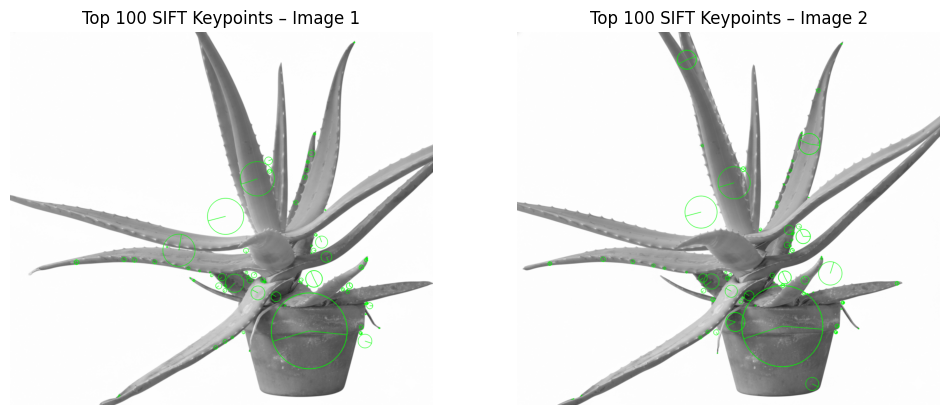

In [ ]:
#STAGE-1
from google.colab import files
import cv2
import matplotlib.pyplot as plt
import os

# --- Step 1: Upload your images ---
print("Upload two images for SIFT keypoint detection")
uploaded = files.upload()

# Get the filenames automatically
filenames = list(uploaded.keys())
if len(filenames) < 2:
    raise ValueError(" Please upload at least two images.")

img1_path = filenames[0]
img2_path = filenames[1]

# --- Step 2: Load images in grayscale ---
img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

# --- Step 4: Initialize SIFT detector ---
sift = cv2.SIFT_create()

# --- Step 5: Detect keypoints and descriptors ---
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# --- Step 6: Keep top 100 strongest keypoints ---
kp1 = sorted(kp1, key=lambda x: -x.response)[:100]
kp2 = sorted(kp2, key=lambda x: -x.response)[:100]

# --- Step 7: Draw keypoints ---
img1_kp = cv2.drawKeypoints(img1, kp1, None, color=(0,255,0),
                            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_kp = cv2.drawKeypoints(img2, kp2, None, color=(0,255,0),
                            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# --- Step 8: Save results ---
cv2.imwrite('sift_keypoints_img1.png', img1_kp)
cv2.imwrite('sift_keypoints_img2.png', img2_kp)

# --- Step 9: Display results ---
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img1_kp, cv2.COLOR_BGR2RGB))
plt.title('Top 100 SIFT Keypoints – Image 1')
plt.axis('off')

plt.subplot(122)
plt.imshow(cv2.cvtColor(img2_kp, cv2.COLOR_BGR2RGB))
plt.title('Top 100 SIFT Keypoints – Image 2')
plt.axis('off')

plt.show()


 Upload two images to match keypoints


Saving aloe1.png to aloe1 (2).png
Saving aloe2.png to aloe2 (2).png
BFMatcher found 285 matches
FLANN-based matcher found 124 good matches (ratio=0.7)
Saved matched keypoints image as output_match.jpg


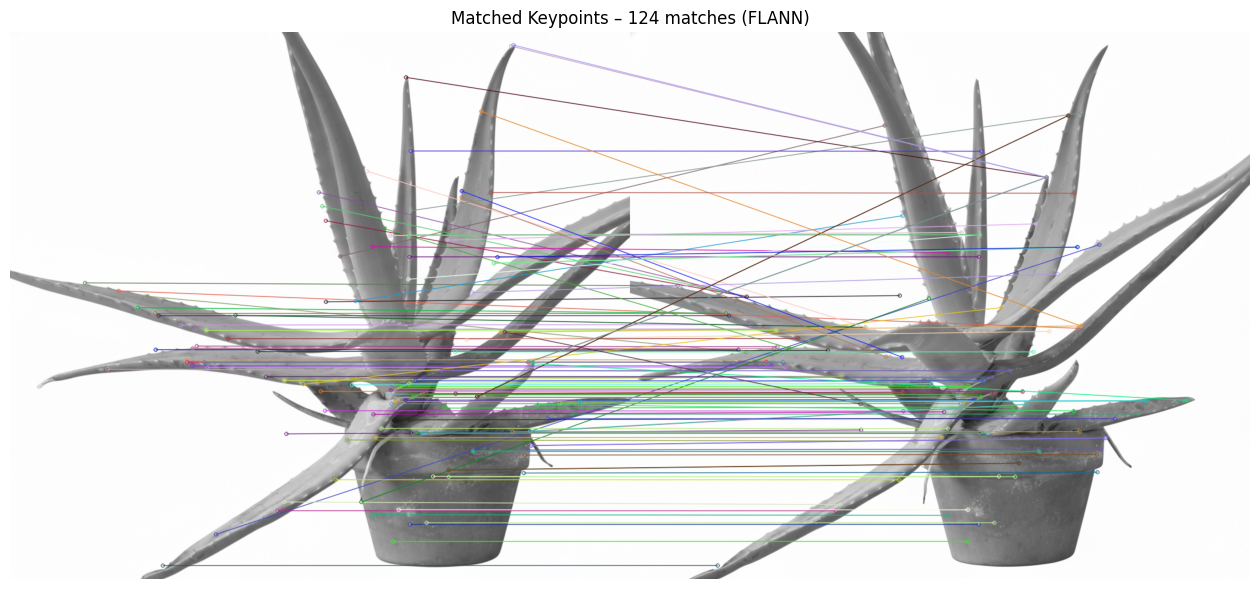

In [ ]:
#STAGE-2
from google.colab import files
import cv2
import matplotlib.pyplot as plt

# --- Step 1: Upload images ---
print(" Upload two images to match keypoints")
uploaded = files.upload()

# Automatically get the filenames
filenames = list(uploaded.keys())
if len(filenames) < 2:
    raise ValueError("Please upload at least two images.")

img1_path = filenames[0]
img2_path = filenames[1]

# --- Step 2: Load images in grayscale ---
img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

if img1 is None or img2 is None:
    raise FileNotFoundError("Could not load one or both images.")

# --- Step 3: Detect SIFT keypoints and descriptors ---
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# --- Stage 2a: BFMatcher (Brute-Force) ---
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)  # crossCheck=True ensures better matches
matches_bf = bf.match(des1, des2)
matches_bf = sorted(matches_bf, key=lambda x: x.distance)  # sort by distance

print(f"BFMatcher found {len(matches_bf)} matches")

# --- Stage 2b: FLANN-based Matcher ---
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches_flann = flann.knnMatch(des1, des2, k=2)

# Apply Lowe's ratio test
good_matches = []
ratio_thresh = 0.7
for m, n in matches_flann:
    if m.distance < ratio_thresh * n.distance:
        good_matches.append(m)

print(f"FLANN-based matcher found {len(good_matches)} good matches (ratio={ratio_thresh})")

# --- Stage 2c: Draw matches (choose one matcher to visualize) ---
# Here we visualize FLANN-based good matches
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None,
                              flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Save output
cv2.imwrite('output_match.jpg', img_matches)
print("Saved matched keypoints image as output_match.jpg")

# --- Stage 2d: Display result ---
plt.figure(figsize=(16,8))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title(f"Matched Keypoints – {len(good_matches)} matches (FLANN)")
plt.axis('off')
plt.show()


 Upload two images for geometry estimation


Saving aloe1.png to aloe1.png
Saving aloe2.png to aloe2.png
Total raw matches: 285
 RANSAC threshold = 0.5 pixels → Inliers = 67


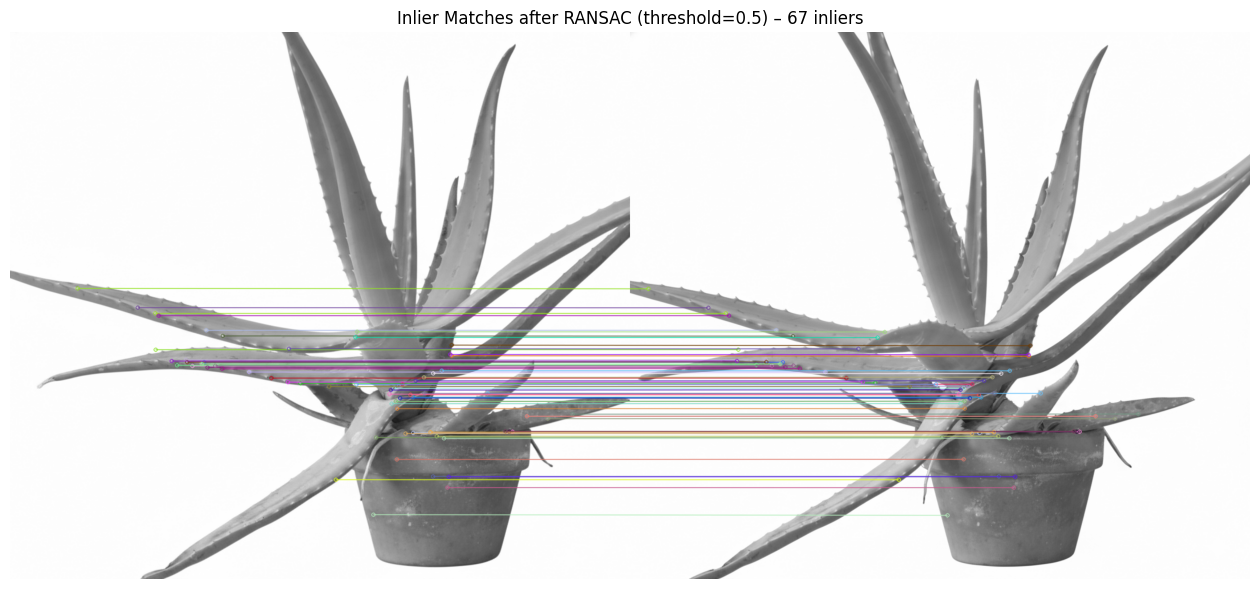

 RANSAC threshold = 1.0 pixels → Inliers = 91


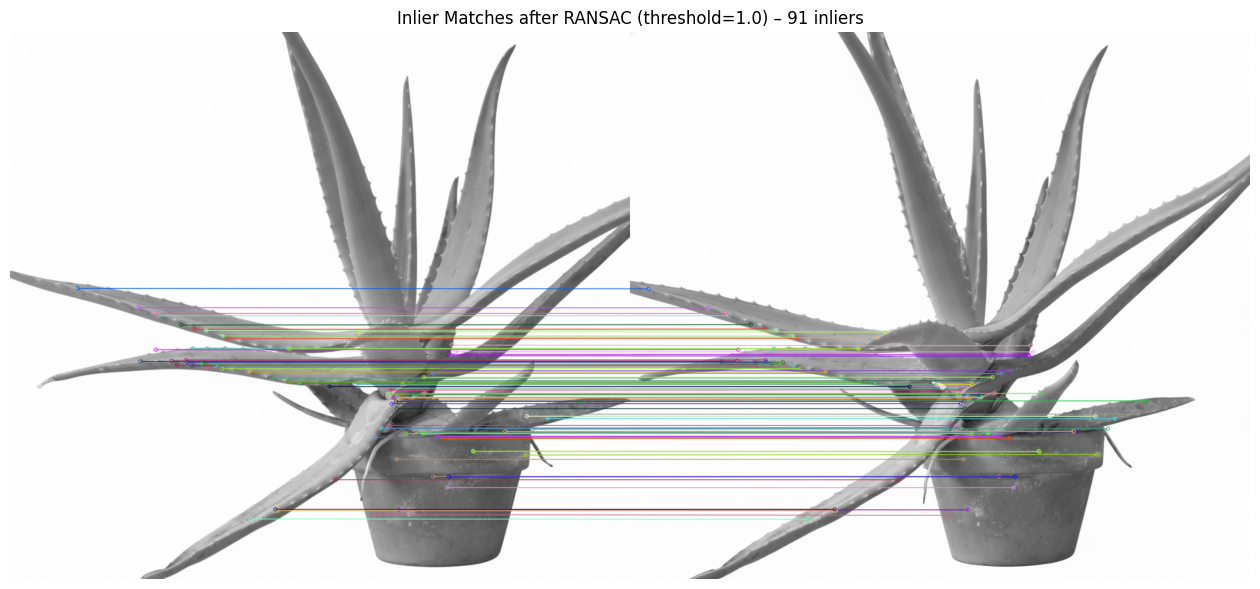

 RANSAC threshold = 5.0 pixels → Inliers = 138


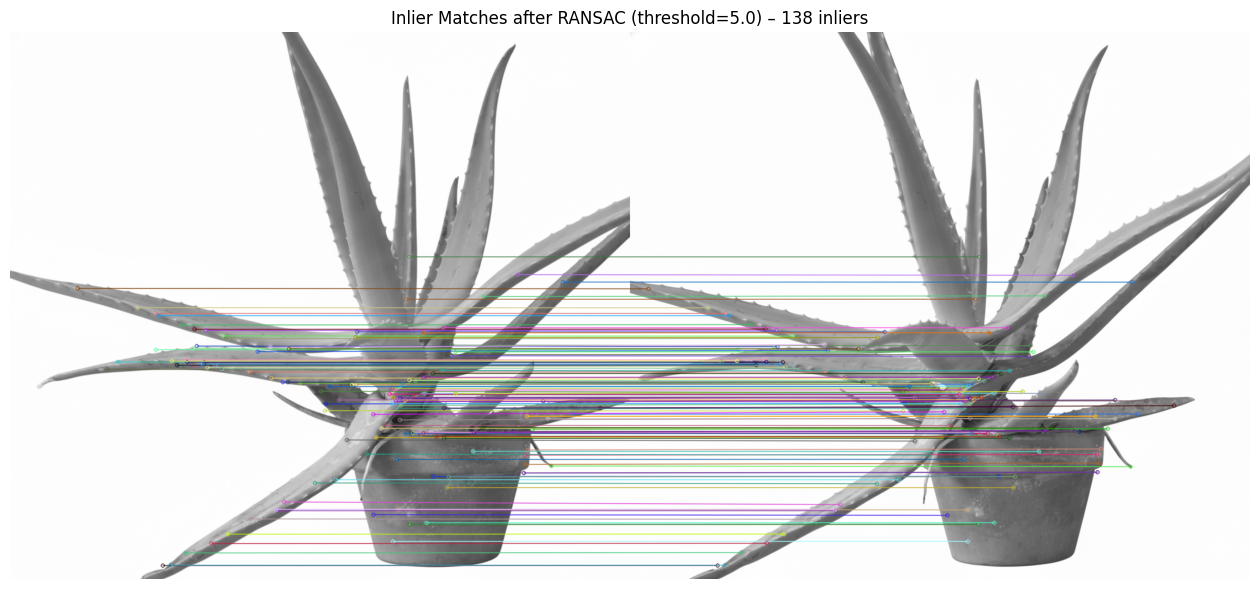


Mini Analysis:
1. The Fundamental Matrix F encodes the epipolar geometry between the two images.
   Each point in image 1 maps to a line (epipolar line) in image 2. Mathematically, x2.T * F * x1 = 0.

2. Changing RANSAC threshold:
   - Smaller threshold (0.5 px) → stricter inlier selection → fewer inliers, higher precision.
   - Moderate threshold (1.0 px) → balance between quantity and quality of inliers.
   - Larger threshold (5.0 px) → more inliers but may include wrong matches → lower accuracy.



In [ ]:
#STAGE-3
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Step 1: Upload images ---
print(" Upload two images for geometry estimation")
uploaded = files.upload()

# Automatically get the filenames
filenames = list(uploaded.keys())
if len(filenames) < 2:
    raise ValueError("Please upload at least two images.")

img1_path = filenames[0]
img2_path = filenames[1]

# --- Step 2: Load images in grayscale ---
img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)


# --- Step 3: Detect SIFT keypoints and descriptors ---
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# --- Step 4: Match keypoints using BFMatcher (crossCheck=True) ---
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)
print(f"Total raw matches: {len(matches)}")

# --- Step 5: Prepare points for Fundamental Matrix ---
pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

# --- Stage 3a: Compute F with RANSAC using different thresholds ---
thresholds = [0.5, 1.0, 5.0]

for thresh in thresholds:
    F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, ransacReprojThreshold=thresh)
    inliers = mask.ravel().sum()
    print(f" RANSAC threshold = {thresh} pixels → Inliers = {inliers}")

    # Draw inlier matches
    inlier_matches = [matches[i] for i in range(len(matches)) if mask[i]]
    img_inliers = cv2.drawMatches(img1, kp1, img2, kp2, inlier_matches, None,
                                  flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    plt.figure(figsize=(16,8))
    plt.imshow(cv2.cvtColor(img_inliers, cv2.COLOR_BGR2RGB))
    plt.title(f"Inlier Matches after RANSAC (threshold={thresh}) – {inliers} inliers")
    plt.axis('off')
    plt.show()

# --- Mini Analysis ---
print("""
Mini Analysis:
1. The Fundamental Matrix F encodes the epipolar geometry between the two images.
   Each point in image 1 maps to a line (epipolar line) in image 2. Mathematically, x2.T * F * x1 = 0.

2. Changing RANSAC threshold:
   - Smaller threshold (0.5 px) → stricter inlier selection → fewer inliers, higher precision.
   - Moderate threshold (1.0 px) → balance between quantity and quality of inliers.
   - Larger threshold (5.0 px) → more inliers but may include wrong matches → lower accuracy.
""")


In [ ]:
#STAGE-4
from google.colab import files
import cv2
import numpy as np

# --- Step 1: Upload images ---
print(" Upload two images for camera pose estimation")
uploaded = files.upload()

filenames = list(uploaded.keys())
if len(filenames) < 2:
    raise ValueError(" Please upload at least two images.")

img1_path = filenames[0]
img2_path = filenames[1]

# --- Step 2: Load images in grayscale ---
img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

# --- Step 3: Detect SIFT keypoints and descriptors ---
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# --- Step 4: Match keypoints ---
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

# --- Step 5: Prepare matched points ---
pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

# --- Step 6: Compute Fundamental Matrix ---
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, ransacReprojThreshold=1.0)
pts1_inliers = pts1[mask.ravel() == 1]
pts2_inliers = pts2[mask.ravel() == 1]

print(f"Fundamental Matrix computed, inliers: {len(pts1_inliers)}")

# --- Step 7: Assume intrinsic camera matrix K ---
# Example: fx=fy=800, cx=cy=width/2,height/2
h, w = img1.shape
fx = fy = 800
cx = w / 2
cy = h / 2
K = np.array([[fx,  0, cx],
              [ 0, fy, cy],
              [ 0,  0,  1]])

# --- Step 8: Compute Essential Matrix ---
E = K.T @ F @ K
print("Essential Matrix E computed")

# --- Step 9: Recover pose (R and t) ---
_, R, t, mask_pose = cv2.recoverPose(E, pts1_inliers, pts2_inliers, K)

print(" Rotation matrix R:")
print(R)
print("\n Translation vector t (up to scale):")
print(t)

# --- Step 10: Save R and t to a text file ---
with open("pose.txt", "w") as f:
    f.write("Rotation matrix R:\n")
    f.write(np.array2string(R, precision=4, separator=', '))
    f.write("\n\nTranslation vector t:\n")
    f.write(np.array2string(t, precision=4, separator=', '))

print("💾 Saved R and t to pose.txt")


 Upload two images for camera pose estimation


Saving aloe1.png to aloe1 (2).png
Saving aloe2.png to aloe2 (2).png
Fundamental Matrix computed, inliers: 91
Essential Matrix E computed
 Rotation matrix R:
[[ 0.99994627 -0.00402226 -0.00955352]
 [ 0.00423146  0.99974946  0.02197966]
 [ 0.00946272 -0.0220189   0.99971277]]

 Translation vector t (up to scale):
[[-9.99523074e-01]
 [-7.88100719e-04]
 [ 3.08707405e-02]]
💾 Saved R and t to pose.txt


Upload two images for 3D reconstruction


Saving aloe1.png to aloe1 (4).png
Saving aloe2.png to aloe2 (4).png
 Inliers after RANSAC: 91


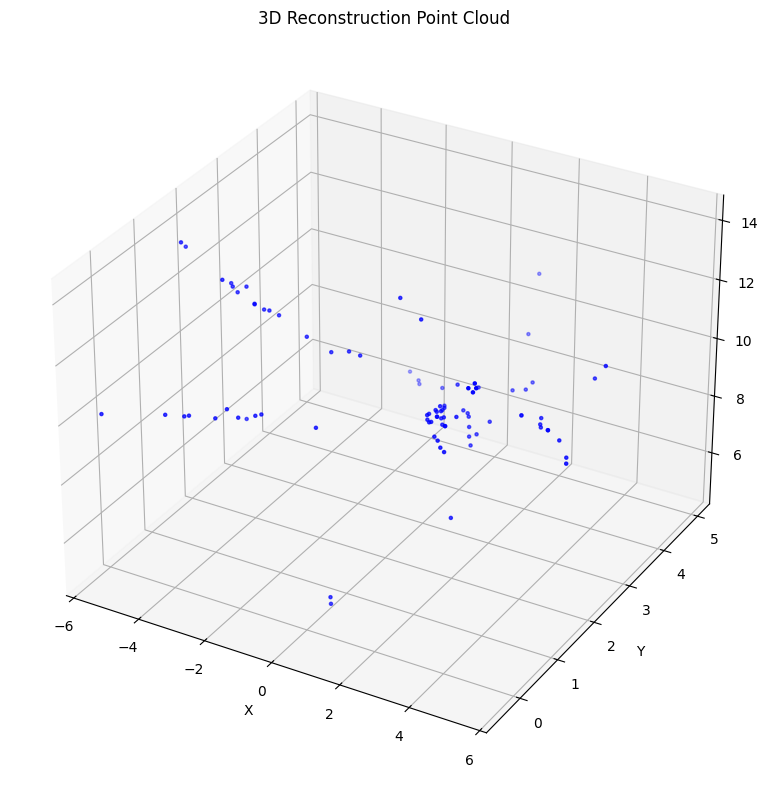

 Saved 3D reconstruction as reconstruction.png


In [ ]:
#STAGE-5
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Step 1: Upload images ---
print("Upload two images for 3D reconstruction")
uploaded = files.upload()

filenames = list(uploaded.keys())
if len(filenames) < 2:
    raise ValueError(" Please upload at least two images.")

img1_path = filenames[0]
img2_path = filenames[1]

# --- Step 2: Load images in grayscale ---
img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

# --- Step 3: Detect SIFT keypoints and descriptors ---
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# --- Step 4: Match keypoints ---
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

# --- Step 5: Prepare matched points ---
pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

# --- Step 6: Compute Fundamental Matrix and filter inliers ---
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, ransacReprojThreshold=1.0)
pts1_inliers = pts1[mask.ravel() == 1]
pts2_inliers = pts2[mask.ravel() == 1]
print(f" Inliers after RANSAC: {len(pts1_inliers)}")

# --- Step 7: Assume intrinsic matrix K ---
h, w = img1.shape
fx = fy = 800
cx = w / 2
cy = h / 2
K = np.array([[fx,  0, cx],
              [ 0, fy, cy],
              [ 0,  0,  1]])

# --- Step 8: Compute Essential Matrix ---
E = K.T @ F @ K

# --- Step 9: Recover pose ---
_, R, t, mask_pose = cv2.recoverPose(E, pts1_inliers, pts2_inliers, K)

# --- Step 10: Build projection matrices ---
# First camera at origin
P1 = K @ np.hstack((np.eye(3), np.zeros((3,1))))
# Second camera at recovered pose
P2 = K @ np.hstack((R, t))

# --- Step 11: Triangulate points ---
pts4D_hom = cv2.triangulatePoints(P1, P2, pts1_inliers.T, pts2_inliers.T)
pts3D = pts4D_hom[:3] / pts4D_hom[3]  # convert from homogeneous to 3D

# --- Step 12: Visualize 3D points ---
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pts3D[0], pts3D[1], pts3D[2], s=5, c='b', depthshade=True)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Reconstruction Point Cloud')
plt.tight_layout()
plt.savefig('reconstruction.png')
plt.show()

print(" Saved 3D reconstruction as reconstruction.png")


In [ ]:

# stage 6: Precision Tweaker (SIFT vs ORB vs AKAZE)

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from google.colab import files

# --- Upload your images ---
print(" Please upload your two images (left and right views)...")
uploaded = files.upload()
file_names = list(uploaded.keys())
print("Uploaded:", file_names)

if len(file_names) < 2:
    raise ValueError("Please upload two images for the stereo pair!")

# --- Load Images ---
img1 = cv2.imread(file_names[0])
img2 = cv2.imread(file_names[1])
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# --- Helper Function ---
def imwrite(path, img):
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    cv2.imwrite(str(path), img)

# =============================
# === Stage 1: SIFT Baseline ===
# =============================
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

# Match using BF + ratio test
bf = cv2.BFMatcher(cv2.NORM_L2)
matches = bf.knnMatch(des1, des2, k=2)
ratio_thresh = 0.75
good = [m for m, n in matches if m.distance < ratio_thresh * n.distance]

pts1 = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,2)
pts2 = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,2)

F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)
inliers = mask.ravel().astype(bool)
pts1_in, pts2_in = pts1[inliers], pts2[inliers]

# --- Camera intrinsics (assumed) ---
h, w = gray1.shape
f = 800
K = np.array([[f,0,w/2],[0,f,h/2],[0,0,1]])
E = K.T @ F @ K
_, R, t, _ = cv2.recoverPose(E, pts1_in, pts2_in, K)

# Projection matrices
M1 = K @ np.hstack((np.eye(3), np.zeros((3,1))))
M2 = K @ np.hstack((R, t))

pts1_h = pts1_in.T
pts2_h = pts2_in.T
points_h = cv2.triangulatePoints(M1, M2, pts1_h, pts2_h)
points_3d = (points_h[:3] / points_h[3]).T

mask_valid = (points_3d[:,2] > 0) & np.isfinite(points_3d[:,2])
points_3d = points_3d[mask_valid]

# Plot SIFT 3D reconstruction
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d[:,0], points_3d[:,1], points_3d[:,2], s=6, c='blue')
ax.set_title('SIFT 3D Reconstruction')
plt.savefig('reconstruction_sift.png', dpi=200)
plt.close()
print(' SIFT reconstruction done -> reconstruction_sift.png')

# =============================
# === Stage 6: Precision Tweaker (ORB + AKAZE) ===
# =============================
for name, detector in [("ORB", cv2.ORB_create(1000)), ("AKAZE", cv2.AKAZE_create())]:
    print(f"\n{name} detector running...")
    kp1_b, des1_b = detector.detectAndCompute(gray1, None)
    kp2_b, des2_b = detector.detectAndCompute(gray2, None)

    if des1_b is None or des2_b is None:
        print(f"No descriptors found for {name}!")
        continue

    bf_b = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches_b = bf_b.match(des1_b, des2_b)
    matches_b = sorted(matches_b, key=lambda x: x.distance)

    print(f"{name}: {len(matches_b)} matches")

    pts1_b = np.float32([kp1_b[m.queryIdx].pt for m in matches_b]).reshape(-1,2)
    pts2_b = np.float32([kp2_b[m.trainIdx].pt for m in matches_b]).reshape(-1,2)

    if len(pts1_b) < 8:
        print(f"Too few matches for {name} to compute F.")
        continue

    F_b, mask_b = cv2.findFundamentalMat(pts1_b, pts2_b, cv2.FM_RANSAC)
    if F_b is None:
        print(f"Failed to compute F for {name}.")
        continue

    inliers_b = mask_b.ravel().astype(bool)
    pts1_in_b = pts1_b[inliers_b]
    pts2_in_b = pts2_b[inliers_b]

    E_b = K.T @ F_b @ K
    _, R_b, t_b, _ = cv2.recoverPose(E_b, pts1_in_b, pts2_in_b, K)

    M1_b = K @ np.hstack((np.eye(3), np.zeros((3,1))))
    M2_b = K @ np.hstack((R_b, t_b))

    pts1_hb = pts1_in_b.T
    pts2_hb = pts2_in_b.T
    points_hb = cv2.triangulatePoints(M1_b, M2_b, pts1_hb, pts2_hb)
    points3d_b = (points_hb[:3] / points_hb[3]).T

    mask_valid_b = (points3d_b[:,2] > 0) & np.isfinite(points3d_b[:,2])
    points3d_b = points3d_b[mask_valid_b]

    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points3d_b[:,0], points3d_b[:,1], points3d_b[:,2], s=6)
    ax.set_title(f'{name} 3D Reconstruction')
    plt.savefig(f'reconstruction_{name.lower()}.png', dpi=200)
    plt.close()
    print(f' {name} reconstruction saved -> reconstruction_{name.lower()}.png')

print(" Precision Tweaker Summary:")


 Please upload your two images (left and right views)...


Saving aloe1.png to aloe1 (1).png
Saving aloe2.png to aloe2 (1).png
Uploaded: ['aloe1 (1).png', 'aloe2 (1).png']
 SIFT reconstruction done -> reconstruction_sift.png

ORB detector running...
ORB: 276 matches
 ORB reconstruction saved -> reconstruction_orb.png

AKAZE detector running...
AKAZE: 580 matches
 AKAZE reconstruction saved -> reconstruction_akaze.png
 Precision Tweaker Summary:


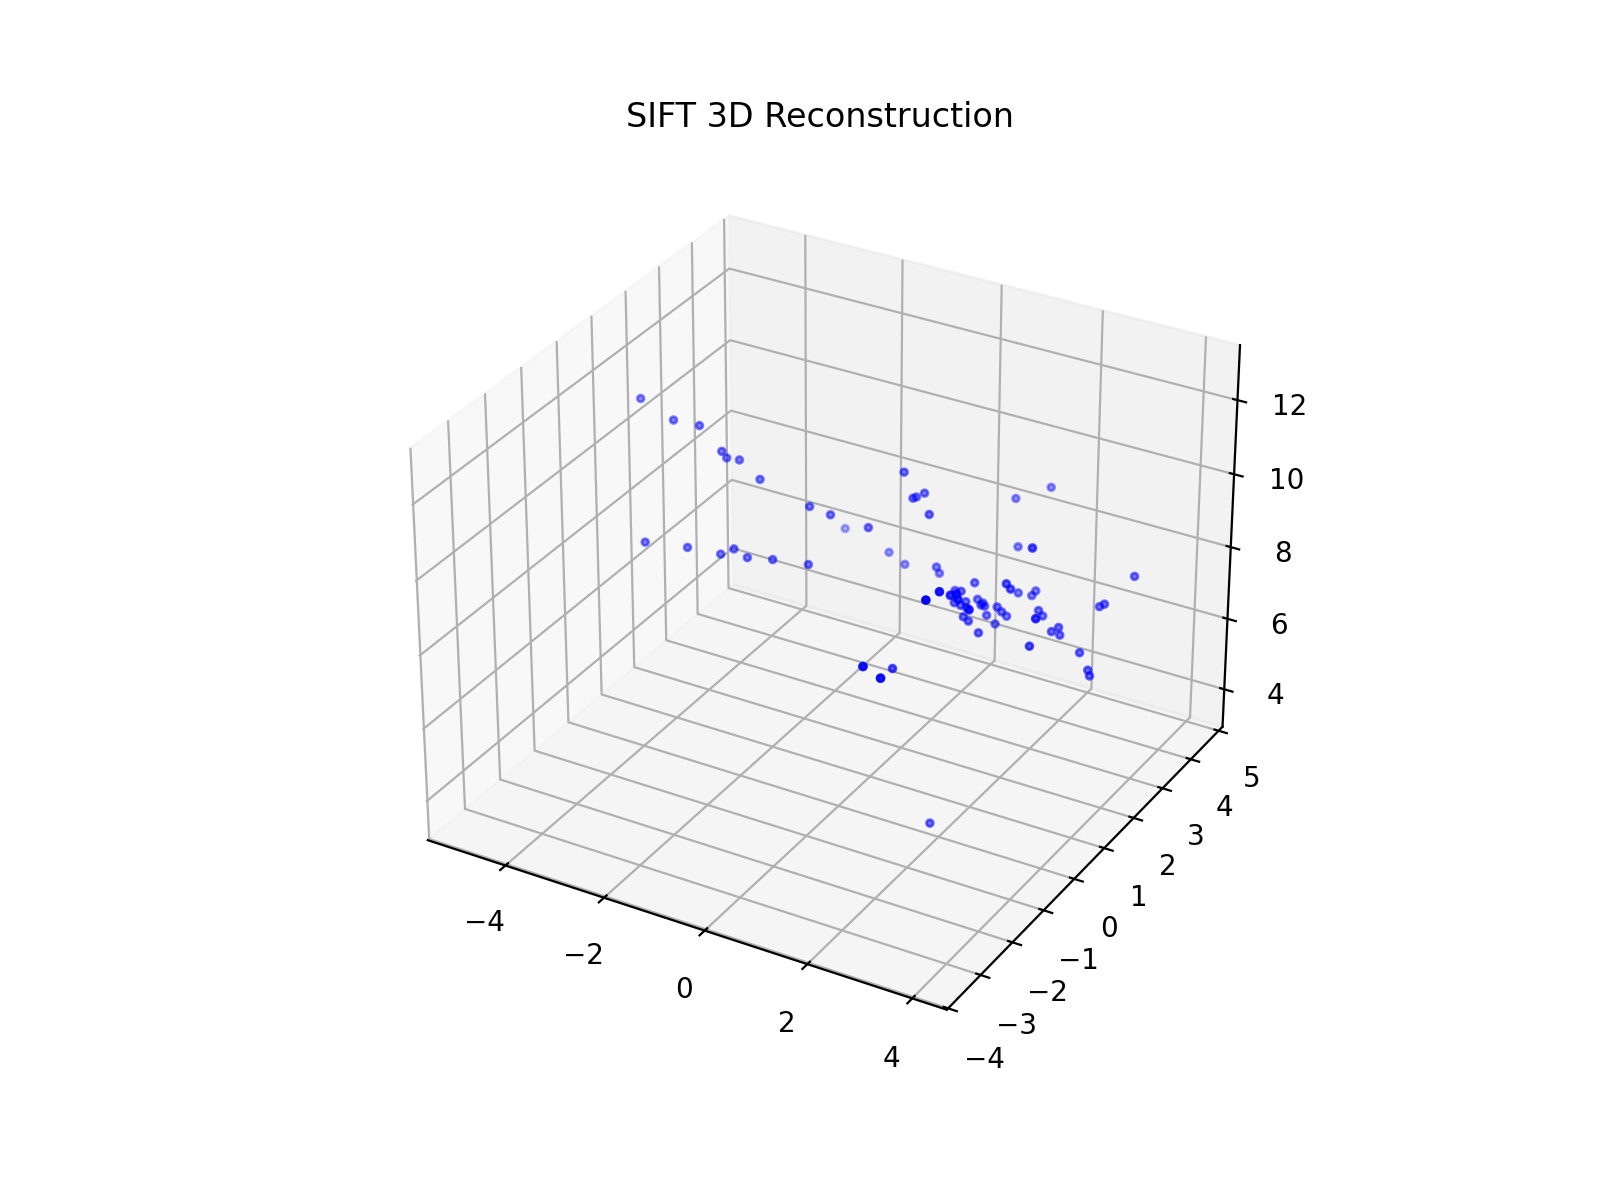

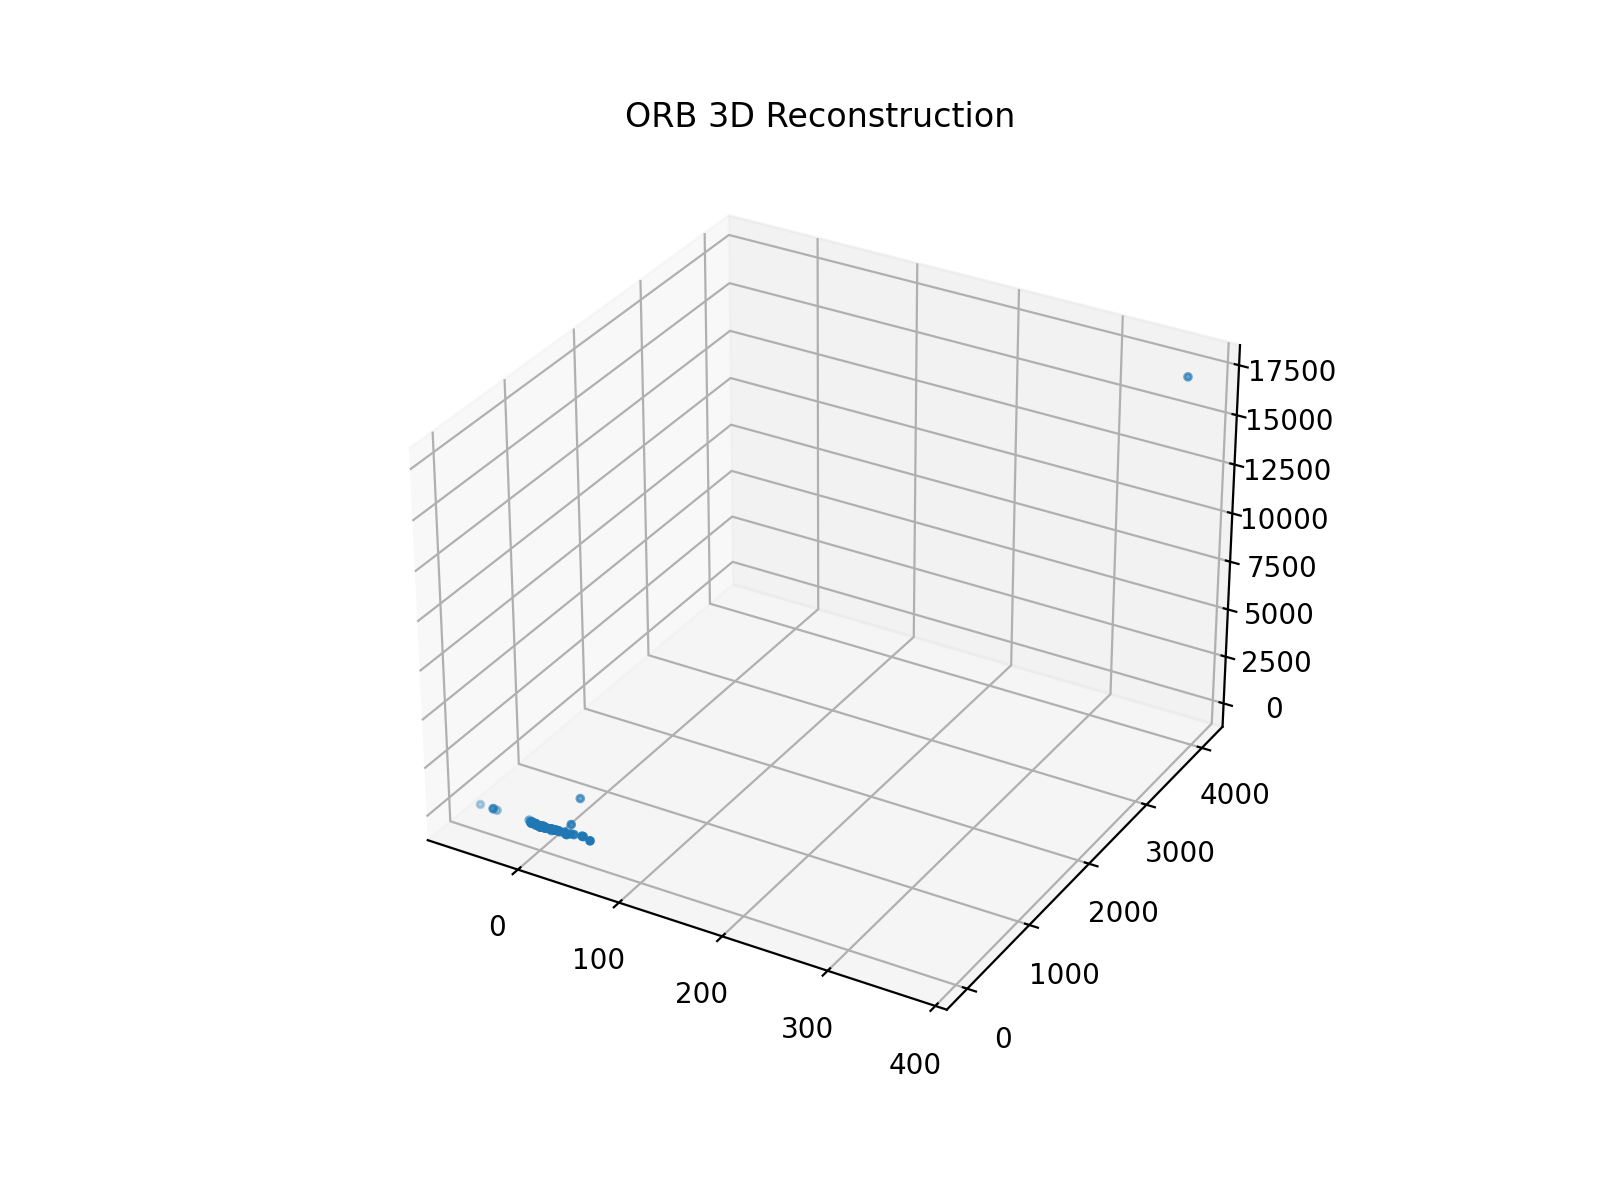

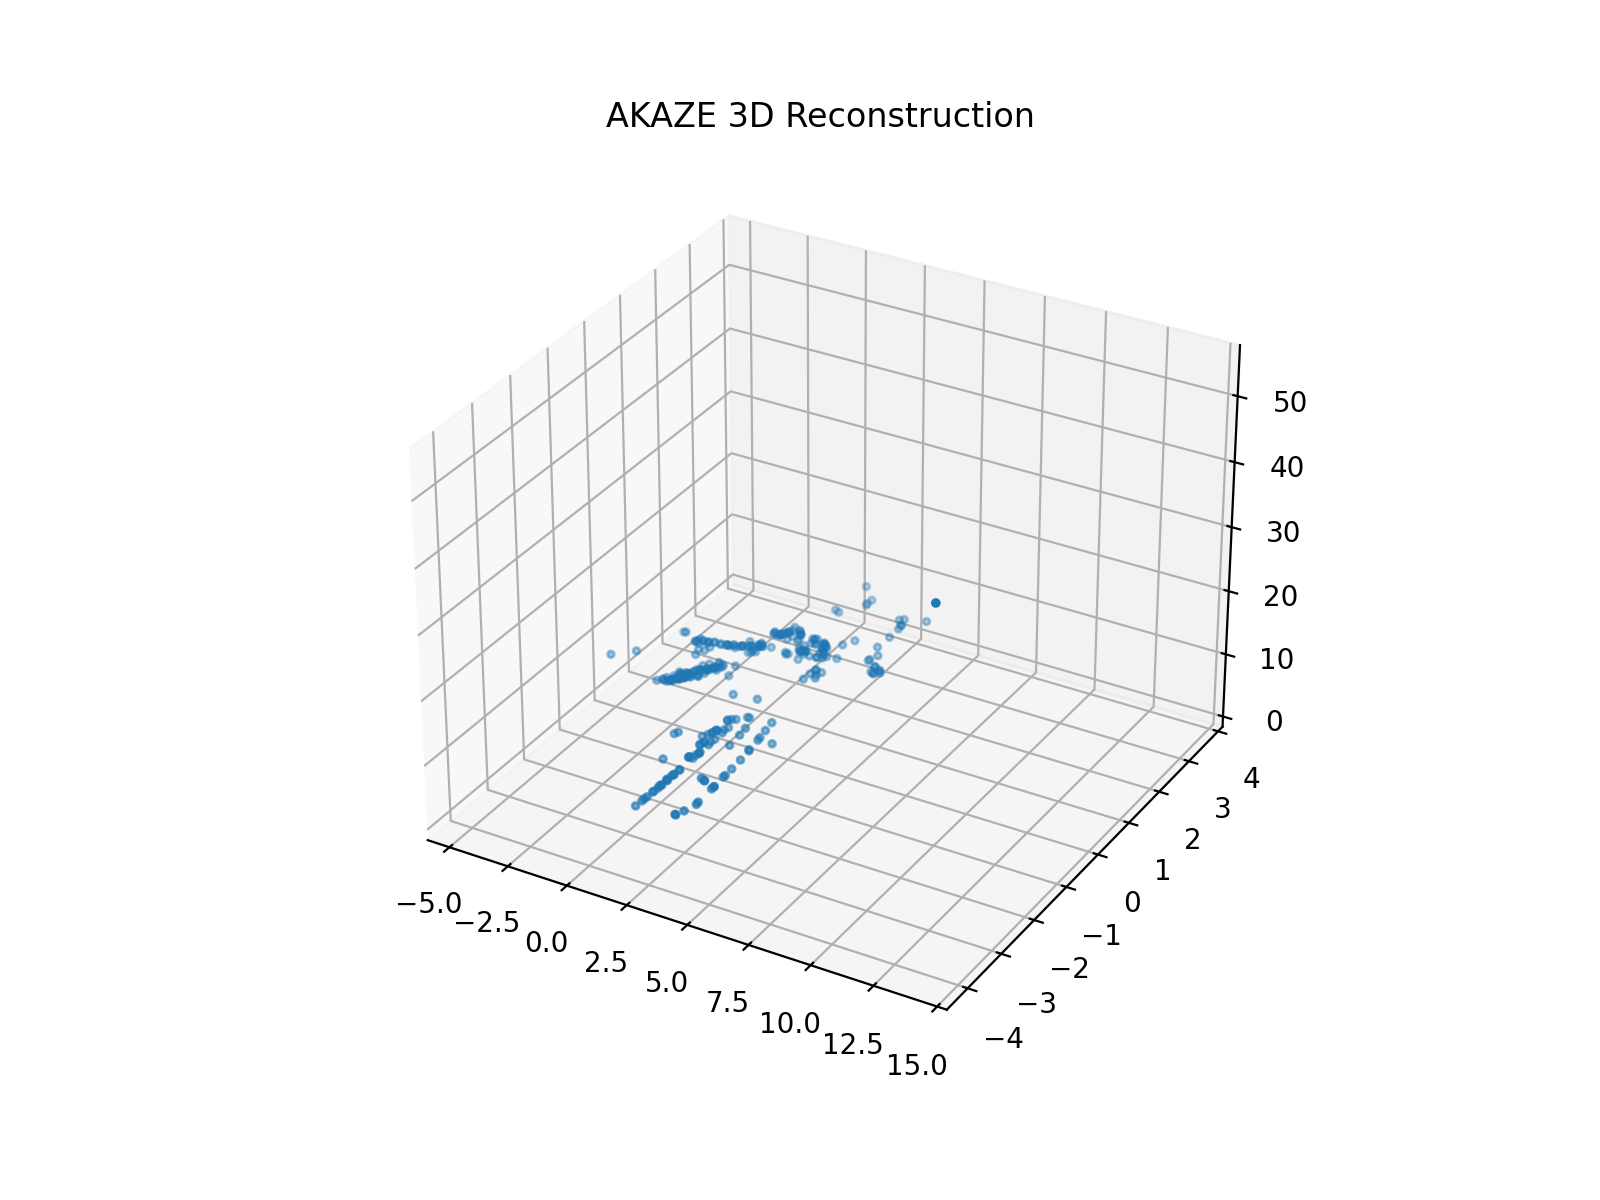

In [ ]:
from IPython.display import Image, display

display(Image(filename='reconstruction_sift.png'))
display(Image(filename='reconstruction_orb.png'))
display(Image(filename='reconstruction_akaze.png'))


In [ ]:
## Stage 1 – Feature Hunt (SIFT Keypoints)

**Mini Analysis:**
- Keypoints cover textured and distinctive areas.
- Dense coverage ensures better chances of correct matches in the next stage.

---

## Stage 2 – Feature Matchmaker

**Mini Analysis:**
- Increasing the ratio threshold reduces false matches but may remove some valid matches.
- Enabling crossCheck improves match reliability but slightly reduces total matches.

---

## Stage 3 – Geometry Guru (Fundamental Matrix & RANSAC)

**Mini Analysis:**
- Smaller RANSAC thresholds give higher geometric accuracy but fewer inliers.
- Larger thresholds increase inliers but may include outliers.
- Fundamental Matrix encodes epipolar geometry between the two views.

---

## Stage 4 – Pose Explorer

**Mini Analysis:**
- Translation vector t represents direction and magnitude of relative camera motion.
- If cameras are uncalibrated, the scale of t and accuracy of R are unknown, which may distort 3-D reconstruction.

---

## Stage 5 – 3-D Builder

**Mini Analysis:**
- Flattened reconstruction may indicate a small camera baseline or calibration errors.
- Depth variation is limited if cameras are too close or intrinsics are inaccurate.

---

## Stage 6 – Creative Visualization (Optional)

**Option B – Precision Tweaker:**
- Different detectors yield different numbers and distributions of keypoints.
- SIFT is more stable, producing more accurate 3-D reconstruction.
- ORB/AKAZE are faster but less precise, reducing reconstruction quality.
- Comparing detectors shows the trade-off between stability and runtime.